In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense,Dropout
from tensorflow.keras.optimizers import Adam
import pickle
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def load_data(filename):
    return pd.read_csv(filename)

In [ ]:
data = load_data('/content/drive/MyDrive/Stockmodeltrainfinal/datastocks/applefinal.csv')
data['Close_Next_Day'] = data['Close'].shift(-1)  # Generate target
data.dropna(inplace=True)

# Define features and target
features = ['Open', 'High', 'Low', 'Close', 'garman_klass_vol', 'rsi_standardized', 'bb_low', 'bb_mid', 'bb_high', 'atr', 'macd', 'dollar_volume', 'text_analysis_number', 'Close_Percent_Change']
n_steps = 10

In [ ]:
# scaler = MinMaxScaler()
# data[features + ['Close_Next_Day']] = scaler.fit_transform(data[features + ['Close_Next_Day']])

# # Create sequences for training
# def create_sequences(data, features, n_steps):
#     X, y = [], []
#     for i in range(n_steps, len(data)):
#         X.append(data[features].iloc[i-n_steps:i].values)
#         y.append(data['Close_Next_Day'].iloc[i])
#     return np.array(X), np.array(y)

# X_train, y_train = create_sequences(data, features, n_steps)

In [ ]:
scaler = MinMaxScaler()
data[features] = scaler.fit_transform(data[features])

def create_sequences(data, features, n_steps):
    X, y = [], []
    for i in range(n_steps, len(data)):
        X.append(data[features].iloc[i-n_steps:i].values)
        y.append(data['Close_Next_Day'].iloc[i])
    return np.array(X), np.array(y)

# Adjust this function to ensure all data is used for prediction



X_train, y_train = create_sequences(data, features, n_steps)
X_train2, y_train2 = create_sequences(data, features, n_steps)

In [ ]:
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(n_steps, len(features))),
    Dropout(0.2),  # Dropout 20% of the nodes of the previous LSTM layer during training
    LSTM(50),
    Dropout(0.2),  # Another dropout layer after the second LSTM layer
    Dense(1)
])
model.compile(optimizer=Adam(), loss='mean_squared_error')

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('/content/drive/MyDrive/Eachstocktrain0516/Modelcheckpoint', monitor='val_loss', save_best_only=True, save_weights_only=False)

In [ ]:
# history = model.fit(
#     X_train, y_train,
#     epochs=100,  # Common number to start with
#     batch_size=32,  # Common size, balances speed and learning stability
#     validation_split=0.2,  # Typically 20% of training data used for validation
#     callbacks=[early_stopping, model_checkpoint]
# )
# predicted = model.predict(X_train)

In [ ]:

model.fit(X_train, y_train, epochs=1024, batch_size=32)

# Predict using the same data
predicted = model.predict(X_train)

# Inverse transform predictions and actual values for plotting

Epoch 1/1024
109/109 [==============================] - 6s 13ms/step - loss: 5775.7085
Epoch 2/1024
109/109 [==============================] - 1s 12ms/step - loss: 5041.9194
Epoch 3/1024
109/109 [==============================] - 1s 13ms/step - loss: 4606.4751
Epoch 4/1024
109/109 [==============================] - 1s 13ms/step - loss: 4254.2915
Epoch 5/1024
109/109 [==============================] - 1s 12ms/step - loss: 3980.0281
Epoch 6/1024
109/109 [==============================] - 1s 13ms/step - loss: 3758.7271
Epoch 7/1024
109/109 [==============================] - 2s 17ms/step - loss: 3577.4121
Epoch 8/1024
109/109 [==============================] - 2s 19ms/step - loss: 3360.8430
Epoch 9/1024
109/109 [==============================] - 2s 19ms/step - loss: 2955.0002
Epoch 10/1024
109/109 [==============================] - 1s 13ms/step - loss: 2690.3630
Epoch 11/1024
109/109 [==============================] - 1s 12ms/step - loss: 2468.2593
Epoch 12/1024
109/109 [==================

In [ ]:
features = ['Open', 'High', 'Low', 'Close', 'garman_klass_vol', 'rsi_standardized', 'bb_low', 'bb_mid', 'bb_high', 'atr', 'macd', 'dollar_volume', 'text_analysis_number',]

index_of_close = features.index('Close')

close_min1 = scaler.min_[index_of_close]
close_scale1 = scaler.scale_[index_of_close]
predicted_prices = (predicted - close_min1) / close_scale1

close_min1 = scaler.min_[index_of_close]
close_scale1 = scaler.scale_[index_of_close]
actual_prices = (y_train.reshape(-1,1) - close_min1) / close_scale1

In [ ]:
# predicted_prices = scaler.inverse_transform(predicted)
# actual_prices = scaler.inverse_transform(np.hstack([X_train[:,:,-1], y_train.reshape(-1,1)]))[:, -1]

In [ ]:
# predicted_prices = predicted
# actual_prices = y_train

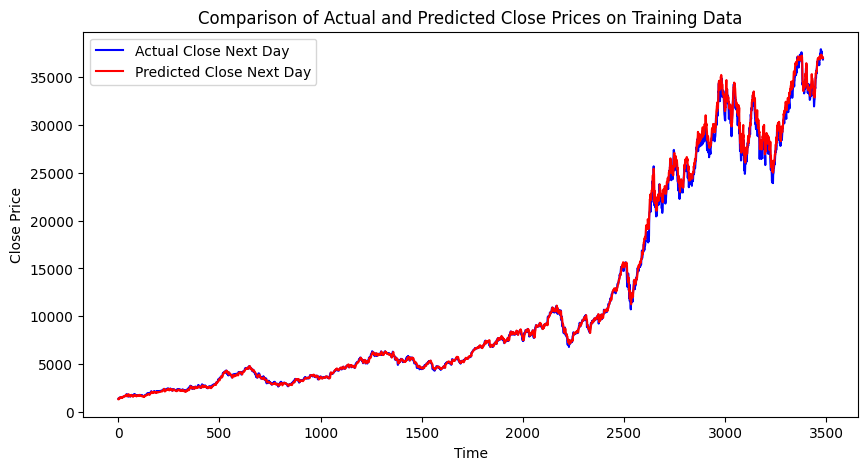

In [ ]:
import matplotlib.pyplot as plt


#predicted_prices = scaler.inverse_transform(predicted)
#actual_prices = scaler.inverse_transform(y_train.reshape(-1, 1))

# Plotting predictions against actual values
plt.figure(figsize=(10, 5))
plt.plot(actual_prices, label='Actual Close Next Day', color='blue')
plt.plot(predicted_prices, label='Predicted Close Next Day', color='red')
plt.title('Comparison of Actual and Predicted Close Prices on Training Data')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.legend()
plt.show()

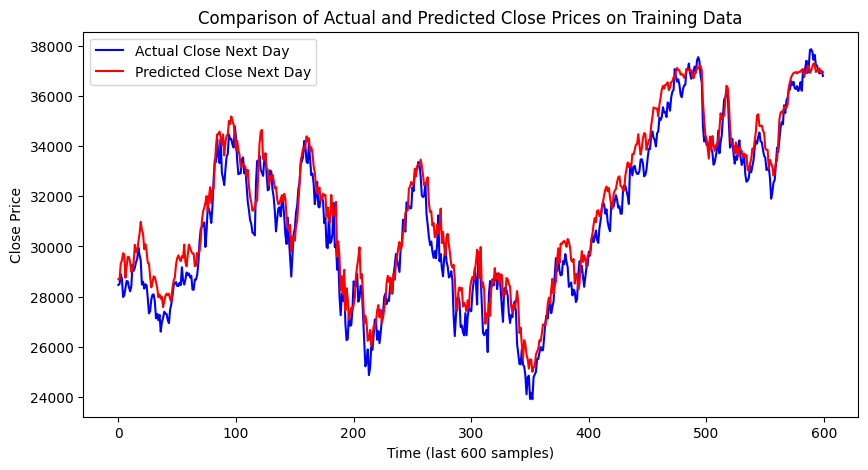

In [ ]:
plt.figure(figsize=(10, 5))
plt.plot(actual_prices[-600:], label='Actual Close Next Day', color='blue')  # Last 600 actual prices
plt.plot(predicted_prices[-600:], label='Predicted Close Next Day', color='red')  # Last 600 predicted prices
plt.title('Comparison of Actual and Predicted Close Prices on Training Data')
plt.xlabel('Time (last 600 samples)')
plt.ylabel('Close Price')
plt.legend()
plt.show()

In [ ]:
model.save('/content/drive/MyDrive/Eachstocktrain0516/MicrosoftLSTM/modelsave')
import pickle
scaler_save_path = '/content/drive/MyDrive/Eachstocktrain0516/MicrosoftLSTM/scaler.pkl'
with open(scaler_save_path, 'wb') as file:
    pickle.dump(scaler, file)

print("Model and scaler saved successfully.")

NameError: name 'model' is not defined

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Extract the last 600 actual and predicted values
actual_prices_last_600 = actual_prices[-600:]
predicted_prices_last_600 = predicted_prices[-600:]

# Calculate MSE, RMSE, and MAE
mse = mean_squared_error(actual_prices_last_600, predicted_prices_last_600)
rmse = mean_squared_error(actual_prices_last_600, predicted_prices_last_600, squared=False)
mae = mean_absolute_error(actual_prices_last_600, predicted_prices_last_600)

print(f"Mean Squared Error (MSE) for the last 600 predictions: {mse}")
print(f"Root Mean Squared Error (RMSE) for the last 600 predictions: {rmse}")
print(f"Mean Absolute Error (MAE) for the last 600 predictions: {mae}")

Mean Squared Error (MSE) for the last 600 predictions: 709628.560212187
Root Mean Squared Error (RMSE) for the last 600 predictions: 842.3945395194505
Mean Absolute Error (MAE) for the last 600 predictions: 684.3462536892683
